In [183]:
import pandas as pd
import numpy as np
import datetime
import requests
import json
import geopandas as gpd
import statistics
from scipy import stats
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

pd.options.display.max_rows = 999

In [100]:
date_range = []
for i in range(2010,2021):
    days = pd.date_range(start=pd.datetime(i, 3, 1), end=pd.datetime(i, 6, 1))
    date_range.append(days)

In [101]:
date_list = []
for sublist in date_range:
    for item in sublist:
        date_list.append(item)

In [103]:
token = 'j6c7l80ga2ib'

In [105]:
frames = []

for date in date_list:
    url = '''https://api.ebird.org/v2/data/obs/US-NY-061/historic/{}/{}/{}'''.format(date.year, date.month, date.day)
    payload = {}
    headers = {'X-eBirdApiToken': token}
    response = requests.request("GET", url, headers=headers, data = payload)
    frame = pd.DataFrame(response.json())
    frames.append(frame)

In [106]:
all_bird_data = pd.concat(frames)

/Users/marthanorrick/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [107]:
all_bird_data.shape

(74987, 13)

In [108]:
all_bird_data.head()

,comName,howMany,lat,lng,locId,locName,locationPrivate,obsDt,obsReviewed,obsValid,sciName,speciesCode,subId
0,Rock Pigeon,NaN,40.703229,-74.016989,L288752,Battery Park,False,2010-03-01,False,True,Columba livia,rocpig,S6088232
1,Ring-billed Gull,NaN,40.703229,-74.016989,L288752,Battery Park,False,2010-03-01,False,True,Larus delawarensis,ribgul,S6088232
2,Great Black-backed Gull,1.0,40.703229,-74.016989,L288752,Battery Park,False,2010-03-01,False,True,Larus marinus,gbbgul,S6088232
3,Great Cormorant,1.0,40.703229,-74.016989,L288752,Battery Park,False,2010-03-01,False,True,Phalacrocorax carbo,grecor,S6088232
4,European Starling,NaN,40.703229,-74.016989,L288752,Battery Park,False,2010-03-01,False,True,Sturnus vulgaris,eursta,S6088232


In [109]:
all_bird_data['obsDt'] = all_bird_data['obsDt'].astype('datetime64[ns]')

In [110]:
bird_geo = gpd.GeoDataFrame(all_bird_data, geometry=gpd.points_from_xy(all_bird_data.lng, all_bird_data.lat), crs={'init':'epsg:2263'})

In [138]:
lower_man_bird_geo = bird_geo[bird_geo.lat <= 40.75]

In [139]:
count_by_day = lower_man_bird_geo.groupby([lower_man_bird_geo.obsDt.dt.year, lower_man_bird_geo.obsDt.dt.dayofyear])['howMany'].count()
all_nyc_count_by_day = all_bird_data.groupby([all_bird_data.obsDt.dt.year, all_bird_data.obsDt.dt.dayofyear])['howMany'].count()

In [140]:
count_by_day = pd.DataFrame(count_by_day)
all_nyc_count_by_day = pd.DataFrame(all_nyc_count_by_day)

In [141]:
count_by_day.index.set_names(["year", "day"], inplace=True)
all_nyc_count_by_day.index.set_names(["year", "day"], inplace=True)

In [142]:
count_by_day = count_by_day.reset_index()
all_nyc_count_by_day = all_nyc_count_by_day.reset_index()

In [154]:
all_nyc_year = all_bird_data.groupby(all_bird_data.obsDt.dt.year)['howMany'].count().reset_index().rename(columns={'obsDt':'year','howMany':'observations'})
lower_man_year = lower_man_bird_geo.groupby(lower_man_bird_geo.obsDt.dt.year)['howMany'].count().reset_index().rename(columns={'obsDt':'year','howMany':'observations'})

In [155]:
all_nyc_birds_year = all_bird_data.groupby(all_bird_data.obsDt.dt.year)['howMany'].sum().reset_index().rename(columns={'obsDt':'year','howMany':'birds'})
lower_man_birds_year = lower_man_bird_geo.groupby(lower_man_bird_geo.obsDt.dt.year)['howMany'].sum().reset_index().rename(columns={'obsDt':'year','howMany':'birds'})

In [177]:
x = all_nyc_year.year
y = all_nyc_year.observations
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
ypred = results.predict(x)
results.params

/Users/marthanorrick/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


const   -867627.727273
year        433.709091
dtype: float64

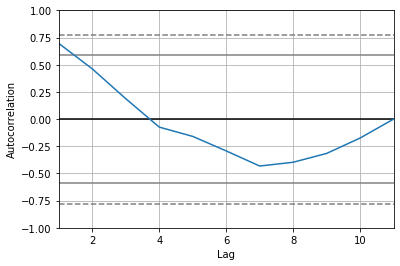

In [182]:
autocorrelation_plot(y);

                             ARIMA Model Results                              
Dep. Variable:         D.observations   No. Observations:                   10
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -76.338
Method:                       css-mle   S.D. of innovations            494.973
Date:                Sun, 21 Jun 2020   AIC                            158.675
Time:                        23:16:31   BIC                            159.583
Sample:                             1   HQIC                           157.679
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  415.4215    112.796      3.683      0.006     194.345     636.498
ar.L1.D.observations    -0.4318      0.305     -1.418      0.194      -1.029       0.165
            

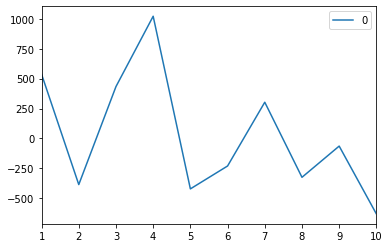

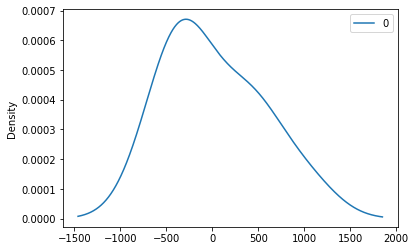

                 0
count    10.000000
mean     23.167906
std     526.867696
min    -632.192604
25%    -371.466140
50%    -147.873172
75%     400.776606
max    1022.111013


In [186]:
model = ARIMA(y, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [178]:
results.summary()

/Users/marthanorrick/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           observations   R-squared:                       0.919
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     101.4
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           3.37e-06
Time:                        23:11:07   Log-Likelihood:                -81.746
No. Observations:                  11   AIC:                             167.5
Df Residuals:                       9   BIC:                             168.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.676e+05   8.68e+04     -9.999      0.000   -1.06e+06   -6.71e+05
year         433.7091     43.062     10.072      0.000     336.296     531.122
==============================================================================
Omnibus:                        0.272   Durbin-Watson:                   1.624
Prob(Omnibus):                  0.873   Jarque-Bera (JB):                0.080
Skew:                           0.138   Prob(JB):                        0.961
Kurtosis:                       2.687   Cond. No.                     1.28e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0.0
0.0
0.0


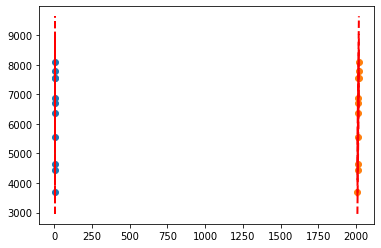

In [176]:
prstd, iv_l, iv_u = wls_prediction_std(results)
t, data, ss2 = summary_table(results, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

# Check we got the right things
print(np.max(np.abs(results.fittedvalues - fittedvalues)))
print(np.max(np.abs(iv_l - predict_ci_low)))
print(np.max(np.abs(iv_u - predict_ci_upp)))

plt.plot(x, y, 'o')
plt.plot(x, ypred, '-', lw=2)
plt.plot(x, predict_ci_low, 'r--', lw=2)
plt.plot(x, predict_ci_upp, 'r--', lw=2)
plt.plot(x, predict_mean_ci_low, 'r--', lw=2)
plt.plot(x, predict_mean_ci_upp, 'r--', lw=2)
plt.show()

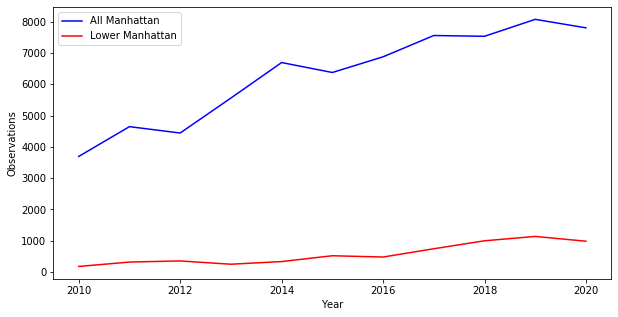

In [152]:
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('Year')
plt.ylabel('Observations')
plt.plot(all_nyc_year.year, all_nyc_year.observations, color='b', label='All Manhattan')
plt.plot(lower_man_year.year, lower_man_year.observations, color='r', label='Lower Manhattan')
plt.legend()
plt.savefig('observations.png');

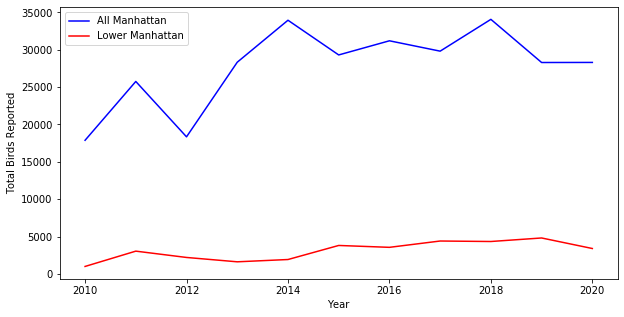

In [156]:
fig, ax = plt.subplots(figsize=(10,5))
plt.xlabel('Year')
plt.ylabel('Total Birds Reported')
plt.plot(all_nyc_birds_year.year, all_nyc_birds_year.birds, color='b', label='All Manhattan')
plt.plot(lower_man_birds_year.year, lower_man_birds_year.birds, color='r', label='Lower Manhattan')
plt.legend()
plt.savefig('birds.png');

In [84]:
array1 = count_by_day[count_by_day.year == 2020]['howMany']
array2 = count_by_day[count_by_day.year == 2019]['howMany']
array3 = count_by_day[count_by_day.year == 2018]['howMany']

array4 = all_nyc_count_by_day[all_nyc_count_by_day.year == 2020]['howMany']
array5 = all_nyc_count_by_day[all_nyc_count_by_day.year == 2019]['howMany']
array6 = all_nyc_count_by_day[all_nyc_count_by_day.year == 2018]['howMany']

In [74]:
stats.f_oneway(array1, array2, array3)

F_onewayResult(statistic=2.2992977091685876, pvalue=0.10227629165760783)

In [85]:
stats.f_oneway(array4, array5, array6)

F_onewayResult(statistic=0.949284142879423, pvalue=0.388277869303961)

In [87]:
all_bird_data.groupby(all_bird_data.obsDt.dt.year).count()

,comName,howMany,lat,lng,locId,locName,locationPrivate,obsDt,obsReviewed,obsValid,sciName,speciesCode,subId,geometry
obsDt,,,,,,,,,,,,,,
2018,7729,7533,7729,7729,7729,7729,7729,7729,7729,7729,7729,7729,7729,7729
2019,8305,8074,8305,8305,8305,8305,8305,8305,8305,8305,8305,8305,8305,8305
2020,8026,7803,8026,8026,8026,8026,8026,8026,8026,8026,8026,8026,8026,8026
